In [74]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
import time

In [75]:
post_rate_val_a = 0.2
post_rate_val_b = 1.5

comment_rate_val = 0.2

new_group_creation_chance_a = 1
new_group_creation_chance_b = 20

existing_group_join_chance_a = 1
existing_group_join_chance_b = 8

niche_score_val_a = 1
niche_score_val_b = 3

thread_popularity_length = 2  # days the thread will remain at max popularity
thread_decay_rate = 0.25  # proportion of popularity lost per day after max popularity

larger_group_join_rate = 1.75  # > 1 means more likely to join larger  groups

In [76]:
class User:
    def __init__(self, acct_id):
        self.id = acct_id
        # The rate at which a post is made
        self.post_rate = stats.beta(post_rate_val_a, post_rate_val_b).rvs()
        # The rate at which a comment is made
        self.comment_rate = round(stats.expon(comment_rate_val).rvs())
        # The chance of making a new group at the creation time of the user
        self.new_group_creation_chance = stats.beta(
            new_group_creation_chance_a, new_group_creation_chance_b
        ).rvs()
        # The chance of joining any existing group at the time of creation of the user and at the end of each round
        self.existing_group_join_chance = stats.beta(
            existing_group_join_chance_a, existing_group_join_chance_b
        ).rvs()
        # A score that increases the probability of commenting and making posts in smaller, more niche groups
        self.niche_score = stats.beta(niche_score_val_a, niche_score_val_b).rvs()
        self.groups = []
        self.posts = []
        self.comments = []


class Group:
    def __init__(self, group_id):
        self.id = group_id
        self.comments = []
        self.user_count = 0


# class Post:
#     def __init__(self, post_id, group_id, user):
#         self.id = post_id
#         self.group_id = group_id
#         self.user = user
#         self.age = 0
#         self.comments = []
#         # How active the post is - this can be useful for visualizations
#         self.current_activity = 1
#         self.highest_activity = 1


class Comment:
    def __init__(self, comment_id, group_id, poster_id, parent_comment_id=None):
        self.id = comment_id
        self.group_id = group_id
        self.poster_id = poster_id
        self.parent_comment_id = parent_comment_id
        
        if parent_comment_id is None:
            # depth of the comment in the chain
            # useful for later visualizations so we don't have to
            # crawl through every comment chain to find the depth
            self.depth = 0
            # only keeping track of age for top level comments
            self.age = 0
            # we only keep track of the activity of the top level comments
            # i.e. the entire comment chain will have the same activity
            self.activity = []
        else:
            self.depth = parent_comment_id.depth + 1



class Simulation:
    def __init__(
        self, num_users, num_groups, user_growth_rate, rounds, round_growth_delay=0
    ):
        self.users = []
        self.groups = []
        self.posts = []
        self.comments = []
        self.user_growth_rate = user_growth_rate
        self.num_users = num_users
        self.num_groups = num_groups
        self.current_time = 0
        self.rounds = rounds
        self.round_growth_delay = round_growth_delay
        self.interaction_matrix = dok_matrix(
            (
                num_users + user_growth_rate * rounds,
                num_users + user_growth_rate * rounds,
            ),
            dtype=np.int32,
        )
        self.initialize()

    def initialize(self):
        # create initial groups
        for i in range(self.num_groups):
            self.groups.append(Group(i))

        # create the users
        for i in range(self.num_users):
            self.add_user(larger_group_join_rate)

    def run(self):
        round_counter = 0
        start_time = time.time()
        for i in range(self.rounds):
            if i % 10 == 0:
                print(i, end=" ")
            round_start_time = time.time()
            self.current_time += 1

            ## Make posts
            self.make_users_post()

            user_post_time = round(time.time() - round_start_time, 2)
            # print("post: ", user_post_time, end=" ")

            ## Make comments
            self.make_users_comment()

            user_comment_time = round(
                time.time() - user_post_time - round_start_time, 2
            )
            # print("comment: ", user_comment_time, end=" ")

            ## Update post age and activity
            self.update_posts()

            post_update_time = round(
                (time.time() - user_comment_time - user_post_time - round_start_time), 2
            )
            # print("update: ", post_update_time, end=" ")

            ## Make users join groups
            self.make_users_join()

            user_group_join_time = (
                time.time()
                - post_update_time
                - user_comment_time
                - user_post_time
                - round_start_time
            )
            # print("join: ", user_group_join_time, end=" ")

            total_round_time = time.time() - round_start_time
            # print("total: ", total_round_time, "\n")

            # add new users
            if self.round_growth_delay != 0 and i % self.round_growth_delay == 0:
                for i in range(self.user_growth_rate):
                    self.add_user(larger_group_join_rate)

            # add new groups based on the user's new group creation chance
            for user in self.users[-self.user_growth_rate :]:
                if np.random.rand() < user.new_group_creation_chance:
                    self.groups.append(Group(len(self.groups)))
                    user.groups.append(self.groups[-1])
                    self.groups[-1].user_count += 1

        total_time = round(time.time() - start_time, 2)
        # print("total_time: ", total_time)

    def make_users_join(self):
        # group weights based on group post activity
        group_weights = []
        for group in self.groups:
            group_activity = 0
            for post in group.posts:
                group_activity += post.current_activity
            group_weights.append(group_activity)

        group_weights = np.array(group_weights)
        group_weights = group_weights / np.sum(group_weights)

        for user in self.users:
            if np.random.rand() < user.existing_group_join_chance:
                # user specific group weights based on their niche score and group size
                user_group_weights = [
                    (group_weight + user.niche_score)
                    * (1 - group.user_count / len(self.users))
                    for group, group_weight in zip(self.groups, group_weights)
                ]

                # normalize
                user_group_weights = np.array(user_group_weights)
                user_group_weights = user_group_weights / np.sum(user_group_weights)

                # weight the groups based on the combined weight
                group = np.random.choice(self.groups, p=user_group_weights)

                if group in user.groups:
                    continue

                user.groups.append(group)
                group.user_count += 1

    def make_users_comment(self):
        # find current activity for all groups
        group_activity = [
            sum([post.current_activity for post in group.posts])
            for group in self.groups
        ]
        group_activity = np.array(group_activity)
        group_activity = group_activity / np.sum(group_activity)

        # makes comments on posts based on post activity
        for user in self.users:
            # users will post user.comment_rate comments in groups that they are a part of
            # and post user.comment_rate comments in all groups

            # if user is only in one group we can skip all of the computationally expensive stuff below
            if len(user.groups) == 1:
                # check if the group has any posts
                if len(user.groups[0].posts) == 0:
                    continue
                rand_group = user.groups[0]
                rand_post_idx = np.random.randint(len(rand_group.posts))
                self.add_comment(user, rand_group.posts[rand_post_idx])
                continue

            # if there is at least one group in the user's group that has more than 0 posts
            if len([group.id for group in user.groups if group.posts != []]) > 0:
                # Calculate group weights based on group size and niche score
                group_weights = [
                    (1 - (group.user_count / len(self.users))) * user.niche_score
                    for group in user.groups
                    if group.posts != []
                ]

                # Normalize the group weights
                group_weights = np.array(group_weights)
                group_weights = group_weights / np.sum(group_weights)

                rand_group_idxs = np.random.choice(
                    a=len([group.id for group in user.groups if group.posts != []]),
                    size=user.comment_rate,
                    p=group_weights,
                )

                for rand_group_idx in rand_group_idxs:
                    rand_group = user.groups[rand_group_idx]
                    if len(rand_group.posts) == 0:
                        continue
                    rand_post_idx = np.random.randint(len(rand_group.posts))
                    self.add_comment(user, rand_group.posts[rand_post_idx])

            # for all groups (still including the groups that the user is in)
            # Calculate group weights based on group size and niche score
            group_weights = [
                (1 - (group.user_count / len(self.users))) * user.niche_score
                for group in self.groups
            ]

            # Normalize the group weights
            group_weights = np.array(group_weights)
            group_weights = group_weights / np.sum(group_weights)

            rand_group_idxs = np.random.choice(
                a=len(self.groups), size=user.comment_rate, p=group_weights
            )

            for rand_group_idx in rand_group_idxs:
                rand_group = self.groups[rand_group_idx]
                if len(rand_group.posts) == 0:
                    continue
                rand_post_idx = np.random.randint(len(rand_group.posts))
                self.add_comment(user, rand_group.posts[rand_post_idx])

    def make_users_post(self):
        # makes posts in groups based on groups size weighted by niche score
        for user in self.users:
            if np.random.rand() < user.post_rate:
                # normalized inverse group size weights
                group_weights = []
                for group in self.groups:
                    # normalize user count to range from 0 to 1
                    # values towards 0 (smaller groups) give a higher weight
                    normalized_user_count = 1 - (group.user_count / len(self.users))
                    group_weight = normalized_user_count * user.niche_score
                    group_weights.append(group_weight)

                # normalize the group weights
                group_weights = np.array(group_weights)
                group_weights = group_weights / np.sum(group_weights)
                # print("GROUP WEIGHTS:", group_weights)

                # weighted selection
                group = self.groups[np.random.choice(len(self.groups), p=group_weights)]
                post = self.add_post(user, group)

    def update_posts(self):
        for post in self.posts:
            post.age += 1
            if post.age <= thread_popularity_length:
                if post.current_activity > post.highest_activity:
                    post.highest_activity = post.current_activity
            else:
                post.current_activity *= 1 - (
                    thread_decay_rate * (post.age - thread_popularity_length)
                )
                if post.current_activity < 1:
                    post.current_activity = 1
                if post.current_activity > post.highest_activity:
                    post.highest_activity = post.current_activity

    def add_user(self, group_join_weight=1.0):
        user = User(len(self.users))
        self.users.append(user)

        # check if user will create a new group
        if np.random.rand() < user.new_group_creation_chance:
            self.groups.append(Group(len(self.groups)))
            user.groups.append(self.groups[-1])
            self.groups[-1].user_count += 1

        # calculate the weights based on group size
        join_weights = [group.user_count + 1 for group in self.groups]

        # adjust the weight
        join_weights = [weight**group_join_weight for weight in join_weights]

        # normalize
        join_weights = np.array(join_weights)
        join_weights = join_weights / np.sum(join_weights)

        # check if user will join any existing groups based on weights
        for group in np.random.choice(
            self.groups, size=len(self.groups), p=join_weights
        ):
            if np.random.rand() < user.existing_group_join_chance:
                # check if user is already in group
                if group in user.groups:
                    continue
                user.groups.append(group)
                group.user_count += 1

        # if user doesn't join any existing groups, join a random group
        if len(user.groups) == 0:
            rand_group = np.random.choice(self.groups)
            # check if user is already in group
            if rand_group in user.groups:
                return user
            user.groups.append(rand_group)
            rand_group.user_count += 1

        return user

    def add_group(self):
        group = Group(len(self.groups))
        self.groups.append(group)
        return group

    def add_post(self, user, group):
        post = Post(len(self.posts), group.id, user)
        user.posts.append(post)
        group.posts.append(post)
        self.posts.append(post)
        return post

    def add_comment(self, user, post):
        comment = Comment(len(self.comments), post.id, post.user.id, user.id)
        user.comments.append(comment)
        post.comments.append(comment)
        post.current_activity += 1
        if post.current_activity > post.highest_activity:
            post.highest_activity = post.current_activity
        self.interaction_matrix[user.id, post.user.id] += 1
        return comment

In [85]:
user_count = 100
group_count = 25
user_growth_rate = 1
total_rounds = 500
growth_delay = 1  # rounds between user growth (i.e. with growth rate of 1 and 100 rounds, 50 users will be added)

sims = []
before_sim_user_group_counts = []
before_sim_group_user_counts = []
after_sim_user_group_counts = []
after_sim_group_user_counts = []

for i in range(1):
    print(i, end=": ")
    sim = Simulation(
        user_count, group_count, user_growth_rate, total_rounds, growth_delay
    )

    before_user_group_counts = [len(user.groups) for user in sim.users]
    before_group_user_counts = [group.user_count for group in sim.groups]

    before_sim_user_group_counts.append(before_user_group_counts)
    before_sim_group_user_counts.append(before_group_user_counts)

    sim.run()
    sims.append(sim)
    print("\n")

    after_user_group_counts = [len(user.groups) for user in sim.users]
    after_group_user_counts = [group.user_count for group in sim.groups]
    after_sim_user_group_counts.append(after_user_group_counts)
    after_sim_group_user_counts.append(after_group_user_counts)

0: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 



Total users: 600
Total groups: 62
Mean interactions 2.1212222222222223
Mean interactions between users who have interacted: 6.3720033710771595
Most active user: 39 with 13672 interactions


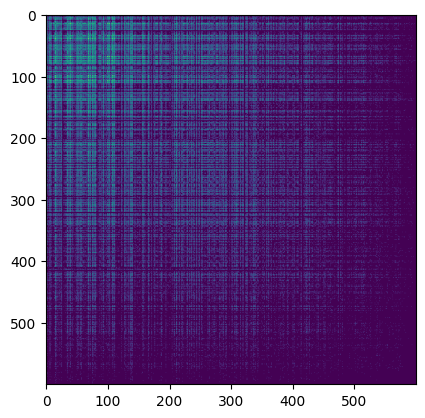

In [86]:
# since the interaction matrix ij only tracks the number of interactions from i to j and not j to i we sum the matrix with its transpose
sim.interaction_matrix = sim.interaction_matrix + sim.interaction_matrix.transpose()

# plot interaction matrix
print("Total users:", len(sim.users))
print("Total groups:", len(sim.groups))
print("Mean interactions", np.mean(sim.interaction_matrix.toarray()))
# finding mean interactions of users who have made at least one interaction with each other
print(
    "Mean interactions between users who have interacted:",
    np.mean(
        sim.interaction_matrix.toarray()[np.where(sim.interaction_matrix.toarray() > 0)]
    ),
)
# finding the most asctive user
print(
    "Most active user:",
    np.argmax(
        np.sum(sim.interaction_matrix.toarray(), axis=1)
        - np.diag(sim.interaction_matrix.toarray())
    ), "with",
    np.max(
        np.sum(sim.interaction_matrix.toarray(), axis=1)
        - np.diag(sim.interaction_matrix.toarray())
    ), "interactions",
)

plt.imshow(np.log(sim.interaction_matrix.toarray() + 1))
plt.show()

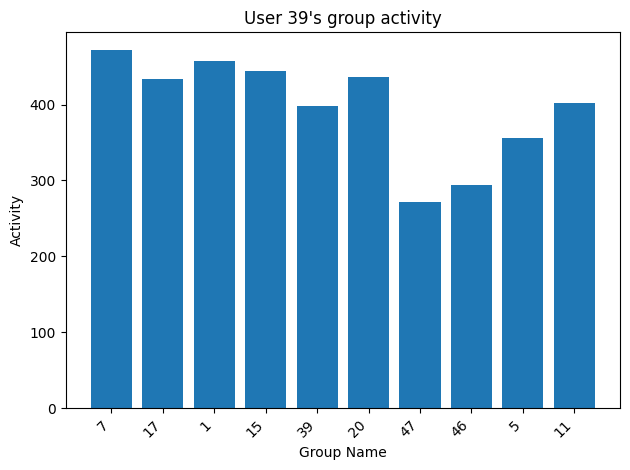

In [93]:
user_id = 39

# Assume sim.users[user_id] is defined and has the necessary attributes

user = sim.users[user_id]
group_activity = []

for group in user.groups:
    # getting activity as well as group id
    group_activity.append(
        (sum([post.current_activity for post in group.posts]), group.id)
    )

# Extracting data for plotting
group_ids = [group[1] for group in group_activity]
activity_values = [group[0] for group in group_activity]

# Bar plot with custom x-axis tick placement
x_positions = np.arange(len(group_ids))
plt.bar(x_positions, activity_values)

# Set x-axis ticks and labels
plt.xticks(x_positions, rotation=45, ha="right")

# Display group IDs beneath the bars
plt.gca().set_xticks(x_positions)
plt.gca().set_xticklabels(group_ids, rotation=45, ha="right")

plt.title("User " + str(user_id) + "'s group activity")
plt.xlabel("Group Name")
plt.ylabel("Activity")

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

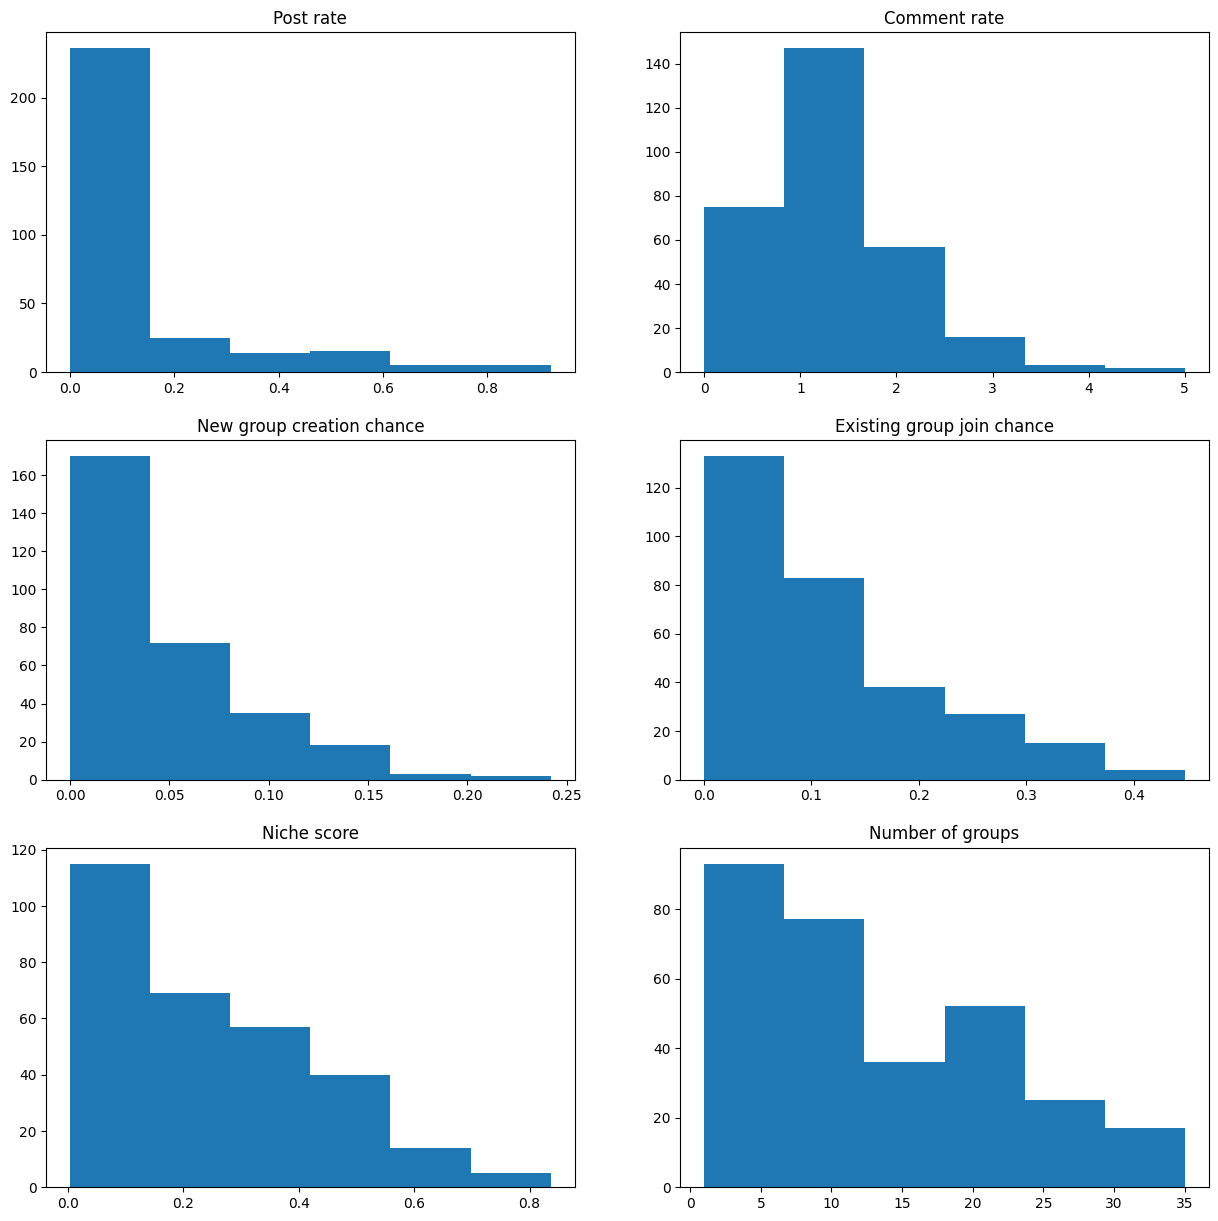

In [79]:
all_user_post_rate = []
all_user_comment_rate = []
all_user_new_group_creation_chance = []
all_user_existing_group_join_chance = []
all_user_niche_score = []
all_user_group_counts = []

for sim in sims:
    all_user_post_rate.extend([user.post_rate for user in sim.users])
    all_user_comment_rate.extend([user.comment_rate for user in sim.users])
    all_user_new_group_creation_chance.extend(
        [user.new_group_creation_chance for user in sim.users]
    )
    all_user_existing_group_join_chance.extend(
        [user.existing_group_join_chance for user in sim.users]
    )
    all_user_niche_score.extend([user.niche_score for user in sim.users])
    all_user_group_counts.extend([len(user.groups) for user in sim.users])

percentage_bin_size = min(
    [
        len(np.unique(all_user_post_rate)),
        len(np.unique(all_user_comment_rate)),
        len(np.unique(all_user_new_group_creation_chance)),
        len(np.unique(all_user_existing_group_join_chance)),
        len(np.unique(all_user_niche_score)),
        len(np.unique(all_user_group_counts)),
    ]
)

# subplot for each user attribute
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs[0, 0].hist(all_user_post_rate, bins=percentage_bin_size)
axs[0, 0].set_title("Post rate")
axs[0, 1].hist(all_user_comment_rate, bins=percentage_bin_size)
axs[0, 1].set_title("Comment rate")
axs[1, 0].hist(all_user_new_group_creation_chance, bins=percentage_bin_size)
axs[1, 0].set_title("New group creation chance")
axs[1, 1].hist(all_user_existing_group_join_chance, bins=percentage_bin_size)
axs[1, 1].set_title("Existing group join chance")
axs[2, 0].hist(all_user_niche_score, bins=percentage_bin_size)
axs[2, 0].set_title("Niche score")
axs[2, 1].hist(all_user_group_counts, bins=percentage_bin_size)
axs[2, 1].set_title("Number of groups")
plt.show()

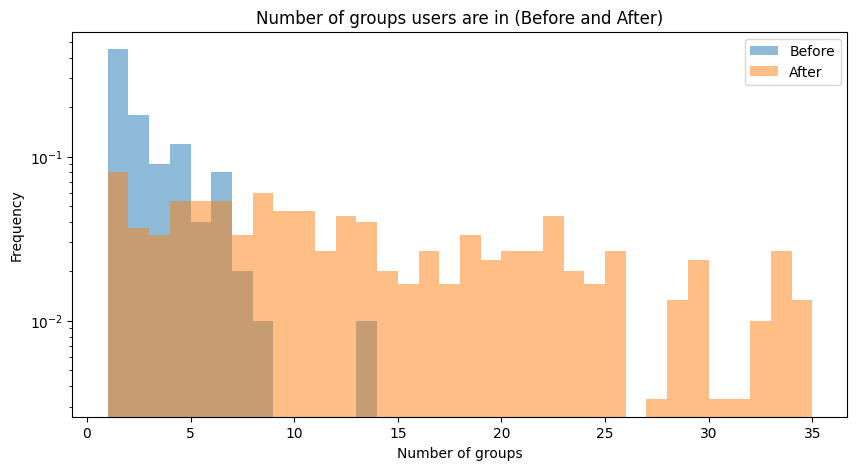

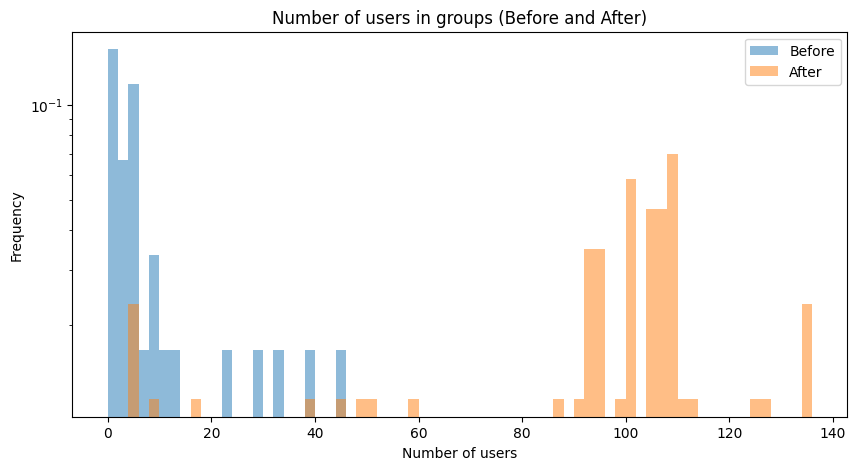

In [84]:
# Create a histogram to compare "before" and "after" user group counts
user_groups_min = min([min(counts) for counts in before_sim_user_group_counts])
user_groups_max = max([max(counts) for counts in after_sim_user_group_counts])
plt.figure(figsize=(10, 5))
plt.hist(
    [count for counts in before_sim_user_group_counts for count in counts],
    alpha=0.5,
    range=(user_groups_min, user_groups_max),
    bins=round((user_groups_max - user_groups_min)),
    density=True,
    label="Before",
    log=True,
)
plt.hist(
    [count for counts in after_sim_user_group_counts for count in counts],
    alpha=0.5,
    range=(user_groups_min, user_groups_max),
    bins=round((user_groups_max - user_groups_min)),
    density=True,
    label="After",
    log=True,
)
plt.title("Number of groups users are in (Before and After)")
plt.xlabel("Number of groups")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Create a histogram to compare "before" and "after" group user counts
group_user_counts_min = min([min(counts) for counts in before_sim_group_user_counts])
group_user_counts_max = max([max(counts) for counts in after_sim_group_user_counts])
plt.figure(figsize=(10, 5))
plt.hist(
    [count for counts in before_sim_group_user_counts for count in counts],
    alpha=0.5,
    range=(group_user_counts_min, group_user_counts_max),
    bins=round((group_user_counts_max - group_user_counts_min) / 2),
    density=True,
    label="Before",
    log=True,
)
plt.hist(
    [count for counts in after_sim_group_user_counts for count in counts],
    alpha=0.5,
    range=(group_user_counts_min, group_user_counts_max),
    bins=round((group_user_counts_max - group_user_counts_min) / 2),
    density=True,
    label="After",
    log=True,
)
plt.title("Number of users in groups (Before and After)")
plt.xlabel("Number of users")
plt.ylabel("Frequency")
# plt.xscale("log")
plt.legend()
plt.show()

In [81]:
sim.interaction_matrix.toarray()

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0, 46, 41, ...,  0,  2,  0],
       [ 0, 41, 26, ...,  0,  1,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  2,  1, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32)

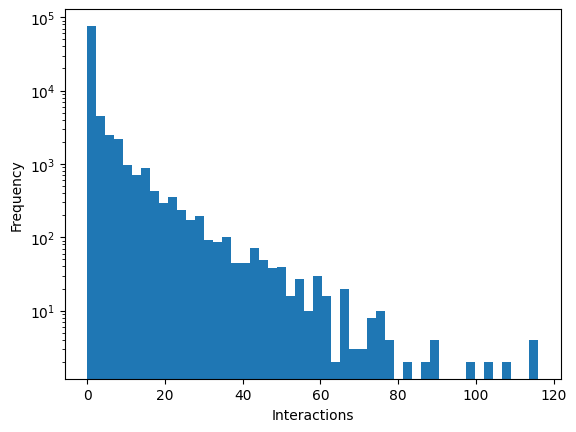

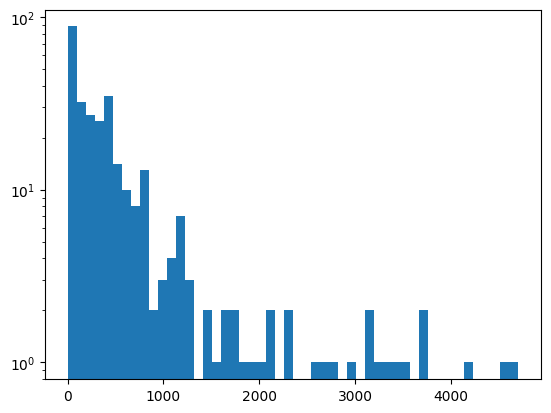

In [82]:
# histogram of userij interactions
plt.hist(
    sim.interaction_matrix.toarray().flatten(),
    bins=50,
    log=True,
)

plt.xlabel("Interactions")
plt.ylabel("Frequency")
plt.show()

# histogram of total user interactions
plt.hist(
    np.sum(sim.interaction_matrix.toarray(), axis=1)
    - np.diag(sim.interaction_matrix.toarray()),
    bins=50,
    log=True,
)
plt.show()